# Attempt 1

In [1]:
!pip install -U -q PyDrive
!pip install rdkit-pypi

import keras
import math
import os
import time
import random
import PIL
import glob
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.keras import layers
from functools import partial
from sklearn.model_selection import KFold
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from rdkit import Chem
from rdkit.Chem.Lipinski import NumAromaticRings
from rdkit.Chem import Draw
from PIL import Image, ImageOps

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# Here I have used 1.7 GB worth of Smiles data

link = 'https://drive.google.com/file/d/1dYQV-fLjF1Yzf678I3EOs2McSyzrHgCc/view?usp=sharing'
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('zinGAN.csv')  
  
df = pd.read_csv('zinGAN.csv')

In [4]:
df2 = df.head(1000)

In [5]:
mol = []
for i in df2['smiles']:
    mol.append(Chem.MolFromSmiles(i))

In [6]:
# Resizing to optimise model

pixel = 80

arr2 = []
for m in mol:
    img = Draw.MolToFile(m,'image.png')
    foo = Image.open("image.png")
    foo = foo.resize((pixel, pixel),Image.ANTIALIAS)
    # foo2.save("image_small.png", optimize=True, quality=95)
    foo = ImageOps.grayscale(foo)
    pix = foo.load()
    arr = []
    for i in range(pixel):
        for j in range(pixel):
            arr.append(pix[i,j])
    arr2.append(arr)
    
trainX = np.array(arr2)

In [7]:
trainX[1].shape

(6400,)

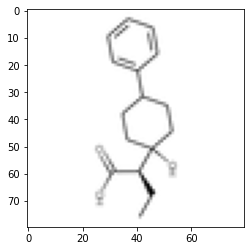

In [8]:
trainX = trainX.reshape(trainX.shape[0], pixel, pixel).astype('float32')
trainX = (trainX - 127.5) / 127.5
plt.imshow(trainX[176], cmap='gray')

In [9]:
# Here I try to use the same model as 

trainX = trainX.reshape(trainX.shape[0], trainX.shape[1]*trainX.shape[2])
trainX = trainX.reshape(trainX.shape[0], pixel, pixel, 1)

In [10]:
def generator_model():
    model = keras.models.Sequential()
    model.add(layers.Dense((pixel//4)*(pixel//4)*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape(((pixel//4),(pixel//4),256)))
    assert model.output_shape == (None, (pixel//4), (pixel//4), 256) 

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, (pixel//4), (pixel//4), 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, (pixel//2), (pixel//2), 64)
    model.add(layers.BatchNormalization())
    model.add(layers. LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, pixel, pixel, 1)
    
    return model

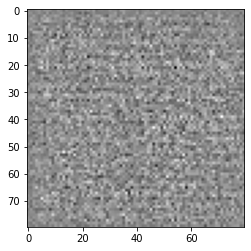

In [11]:
generator = generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [12]:
def discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[pixel, pixel, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))  # 1 output, prob of 5 vs not 5
    return model

In [13]:
discriminator = discriminator_model()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [15]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [16]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [17]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64
EPOCHS = 1000
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [18]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [19]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, generator=generator, discriminator=discriminator)

In [21]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        train_step(dataset)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

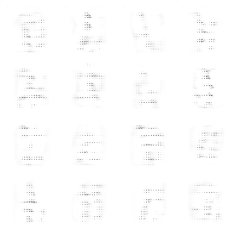

In [22]:
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

train(trainX, EPOCHS)
# Free abstract art

In [23]:
from numpy.random import randn

def generate_latent_points(latent_dim, n_samples):
	x_input = randn(latent_dim * n_samples)
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

latent_points = generate_latent_points(100, 10)
X = generator.predict(latent_points)
X.shape

(10, 80, 80, 1)

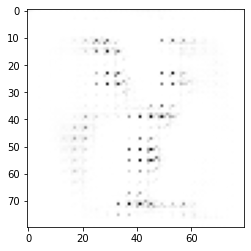

In [24]:
q = random.randint(0,10)
plt.imshow(X[q, :, :, 0], cmap='gray')

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Attempt 2

In [26]:
# Loading libraries
# This model was understood using https://www.cheminformania.com/master-your-molecule-generator-seq2seq-rnn-models-with-smiles-in-keras/
!pip install -U -q PyDrive
!pip install rdkit-pypi

import keras
import math
import os
import time
import random
import PIL
import glob
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.keras import layers
from functools import partial
from sklearn.model_selection import KFold
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from rdkit import Chem
from rdkit.Chem.Lipinski import NumAromaticRings
from rdkit.Chem import Draw, Descriptors
from PIL import Image, ImageOps
from keras import regularizers
from tensorflow.keras.optimizers import Adam
%matplotlib inline


In [27]:
# Loading Dataset

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [28]:
# Here I use a data of ~63k smiles molecules because more aren't required

link = 'https://drive.google.com/file/d/1V1uMEXYG4r1qpDPSvzJC0VUmVmF3n__g/view?usp=sharing'
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile("gdb11_size08.smi")  

smifile = "gdb11_size08.smi"
df = pd.read_csv(smifile, delimiter = "\t", names = ["smiles", "No", "Int"])
df.head()

,smiles,No,Int
0,CC(C)CC(C)(C)C,1,1
1,CC(N)CC(C)(C)C,2,1
2,CC(O)CC(C)(C)C,3,1
3,CC(F)CC(C)(C)C,4,1
4,CC(C)(C)CC(F)F,5,1


In [29]:
X_train, X_test = train_test_split(df["smiles"], test_size=0.2, random_state=189)

print(X_train.shape)
print(X_test.shape)

(53364,)
(13342,)


In [30]:
# Data Preprocessing, this converts each molecule into a vector using a 1-1 dictionary
# We add 8 digits because our discovered drugs might have a size > 22 characters

charset = set("".join(list(df.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in df.smiles]) + 8
print(str(charset))
print(len(charset), embed)

{'=', ']', '+', 'o', '!', '3', '#', 'E', 'N', 'c', 'n', 'O', '4', '[', 'H', 'C', ')', '2', 'F', '-', '(', '1'}
22 31


In [31]:
int_to_char

{0: '=',
 1: ']',
 2: '+',
 3: 'o',
 4: '!',
 5: '3',
 6: '#',
 7: 'E',
 8: 'N',
 9: 'c',
 10: 'n',
 11: 'O',
 12: '4',
 13: '[',
 14: 'H',
 15: 'C',
 16: ')',
 17: '2',
 18: 'F',
 19: '-',
 20: '(',
 21: '1'}

In [32]:
# This represents each molecule as a matrix 30x22
# The X data starts with !, but the output Y is offset by one character, and starts with the first character of the actual SMILES.

def preprocess(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed, len(charset)), dtype=np.int8)
        for i, smile in enumerate(smiles):
            one_hot[i,0,char_to_int["!"]] = 1
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            one_hot[i,len(smile)+1:, char_to_int["E"]] = 1
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
        
X_train, Y_train = preprocess(X_train.values)
X_test, Y_test = preprocess(X_test.values)

In [33]:
X_train[1].shape

(30, 22)

## Training

In [34]:
input_shape = X_train.shape[1:]         # 30, 22 (smiles molecule)
output_dim = Y_train.shape[-1]          # 22 (smiles molecule)
latent_dim = 64
lstm_dim = 64

In [35]:
# Encoder Model
# Here we use LSTMs because in a molecule, we need to know what came before an atom in order to get what comes after

encoder_inputs = layers.Input(shape=input_shape)
encoder = layers.LSTM(lstm_dim, return_state=True, unroll=False)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
states = layers.Concatenate(axis=-1)([state_h, state_c])
neck = layers.Dense(latent_dim, activation="relu")  # latent space
neck_outputs = neck(states)

In [36]:
# Here h and c represent the hidden and cell states respectively

decode_h = layers.Dense(lstm_dim, activation="relu")
decode_c = layers.Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs)
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = layers.Input(shape=input_shape)
decoder_lstm = layers.LSTM(lstm_dim, return_sequences=True, unroll=False)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = layers.Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [37]:
model.compile(optimizer = Adam(0.005), loss='categorical_crossentropy')

In [38]:
model.fit([X_train, X_train], Y_train, epochs=150, batch_size=256, shuffle=True, validation_data=[[X_test, X_test], Y_test])

Epoch 1/150
209/209 [==============================] - 11s 30ms/step - loss: 0.8136 - val_loss: 0.5819
Epoch 2/150
209/209 [==============================] - 5s 25ms/step - loss: 0.5413 - val_loss: 0.5091
Epoch 3/150
209/209 [==============================] - 5s 25ms/step - loss: 0.4950 - val_loss: 0.4814
Epoch 4/150
209/209 [==============================] - 5s 25ms/step - loss: 0.4951 - val_loss: 0.4681
Epoch 5/150
209/209 [==============================] - 5s 25ms/step - loss: 0.4563 - val_loss: 0.4498
Epoch 6/150
209/209 [==============================] - 5s 25ms/step - loss: 0.4309 - val_loss: 0.4172
Epoch 7/150
209/209 [==============================] - 5s 25ms/step - loss: 0.4070 - val_loss: 0.3946
Epoch 8/150
209/209 [==============================] - 5s 24ms/step - loss: 0.3828 - val_loss: 0.3709
Epoch 9/150
209/209 [==============================] - 5s 24ms/step - loss: 0.3679 - val_loss: 0.3657
Epoch 10/150
209/209 [==============================] - 5s 24ms/step - loss: 0.34

In [40]:
# Creating Model

smiles_to_latent = tf.keras.Model(encoder_inputs, neck_outputs)
smiles_to_latent.save("ZinGAN.h5")

In [43]:
# Decoder Model

latent_input = layers.Input(shape=(latent_dim,))
state_h_decoded_2 = decode_h(latent_input)
state_c_decoded_2 = decode_c(latent_input)
latent_to_states = tf.keras.Model(latent_input, [state_h_decoded_2, state_c_decoded_2])
latent_to_states.save("ZinGAN2.h5")

In [44]:
#  Random Sampling Model used to create Smiles from Latent Space

inf_decoder_inputs = layers.Input(batch_shape=(1, 1, input_shape[1]))
inf_decoder_lstm = layers.LSTM(lstm_dim, return_sequences=True, unroll=False, stateful=True)
inf_decoder_outputs = inf_decoder_lstm(inf_decoder_inputs)
inf_decoder_dense = layers.Dense(output_dim, activation='softmax')
inf_decoder_outputs = inf_decoder_dense(inf_decoder_outputs)
sample_model = tf.keras.Model(inf_decoder_inputs, inf_decoder_outputs)

In [45]:
#Transferring the Weights from Encoder

for i in range(1,3):
    sample_model.layers[i].set_weights(model.layers[i+6].get_weights())
sample_model.save("ZinGAN3.h5")

In [46]:
x_latent = smiles_to_latent.predict(X_test)

In [47]:
# Function to Generate molecule 

def create_smiles(latent):
    states = latent_to_states.predict(latent)
    sample_model.layers[1].reset_states(states=[states[0], states[1]])
    startidx = char_to_int["!"]
    samplevec = np.zeros((1,1,22))
    samplevec[0, 0, startidx] = 1
    smiles = ""
    for i in range(31):
        o = sample_model.predict(samplevec)
        sampleidx = np.argmax(o)
        samplechar = int_to_char[sampleidx]
        if samplechar != "E":
            smiles = smiles + int_to_char[sampleidx]
            samplevec = np.zeros((1,1,22))
            samplevec[0,0,sampleidx] = 1
        else:
            break
    return smiles

In [48]:
smiles = create_smiles(x_latent[0:1])


 Smiles Representation 

COc1ncnnc1F
COC(F)C1COC1
COC(C#C)C1CO1
C=NN=CC1CCC1
CON=CCC1CO1
CON=CCC1CC1
COC1(CO)CCC1
OCC(O)CC#CC
CON=CCC1CC1
CON=CCC=CF
CON=C1CC=CO1
COC1=CCCC1(C)
COc1n[nH]nnn1F
CON=CCCC=C
CON=CCC1CC1
CON=CCC1CC1
CON=CCC1CC1
CON=CCC1CC1
N=COC(CF)C=C
CON=CCC1CC1
CON=CCC1CC1
CON=CCC1CC1
CN1OC=CC1CC
CON(CF)C1CC1
CON=CCC1CC1
CON=CCC1CC1
CN=c1nnon1C
CON=CCCC=C
CON=CCC1CC1
CON=CC1CCC1

 Pictorial Representation 



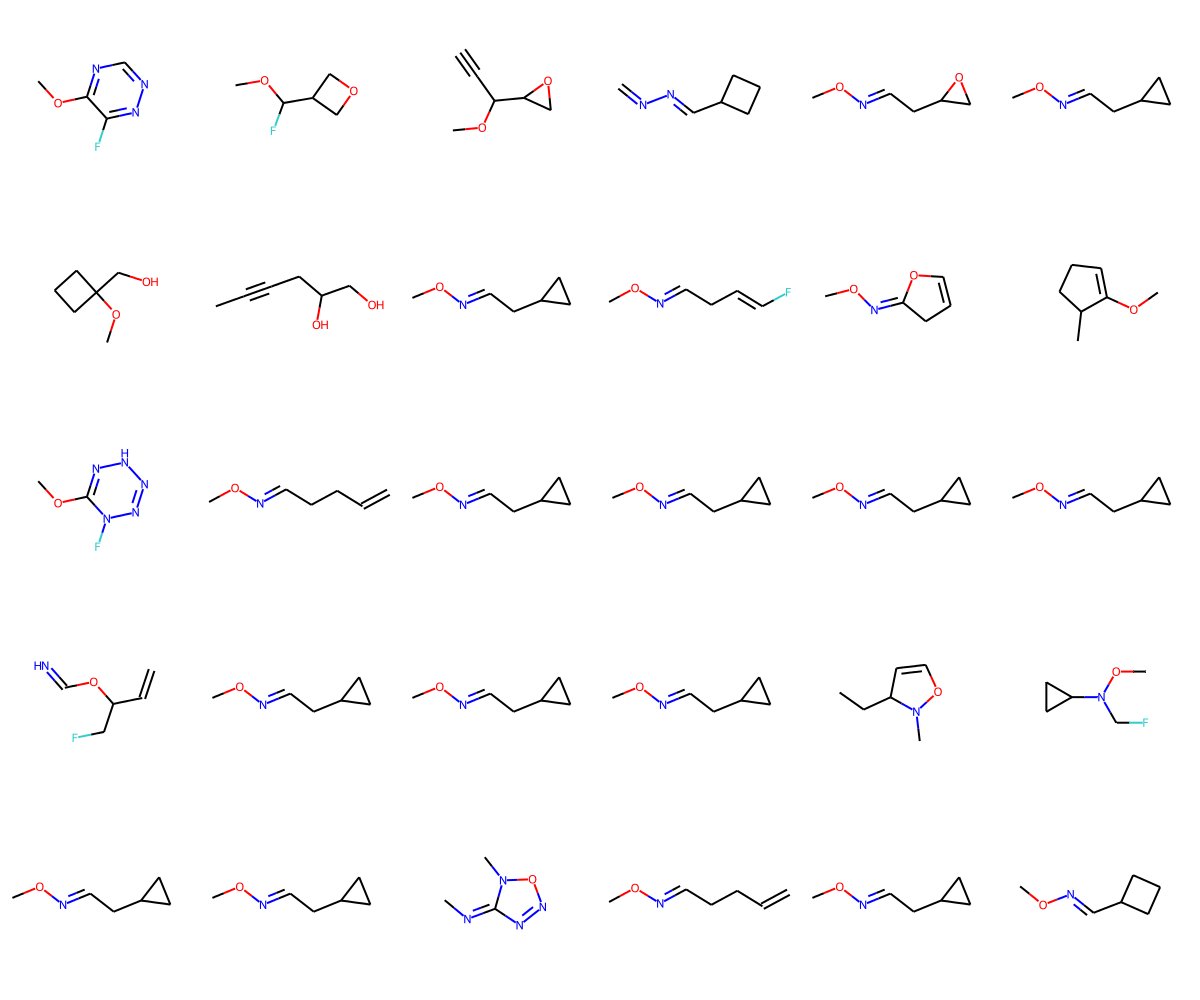

In [53]:
# Creates molecules from random latent space.

latent = x_latent[0:1]
print("\n Smiles Representation \n")
mols = []
while len(mols)<30:
    scale = random.random()
    latent_r = latent + scale*(np.random.randn(latent.shape[1])) #Creates random latent space
    smiles = create_smiles(latent_r)
    mol = Chem.MolFromSmiles(smiles)
    if mol and (smiles not in df.smiles):         # Only appends and prints if it is a molecule AND is not in training data
        mols.append(mol)
        print(smiles)

print("\n Pictorial Representation \n")
Draw.MolsToGridImage(mols, molsPerRow=6)